# Güte der Schadensvorhersage bei echten Schadensfällen, die vom Klassifikationsmodell als FRAUD klassifiziert werden

Es werden die drei Varianten des Regressionsmodells getestet, um zu sehen, ob es Unterschiede in der Güte der Schadensvorhersage gibt. 


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from xgboost import XGBClassifier, XGBRegressor

import fraud_detection as fd
from fraud_detection import data_loader, metrics

datapath = "../data/transformed_label_and_damage.parquet"

In [ ]:
seed = 42
np.random.seed(seed)

In [35]:
def cost_fn(probs, damage, cost_fp, tain_tp=5):
    return probs > cost_fp / (tain_tp + cost_fp + damage)

In [36]:
def get_balanced_data(X_train, y_train, seed=42):
    n_damage = np.sum(y_train[:, 1] > 0)
    n_no_damage = np.sum(y_train[:, 1] == 0)
    n_samples = min(n_damage, n_no_damage)
    idx_balanced = np.concatenate([
            np.random.choice(np.where(y_train[:, 1] > 0)[0], n_samples, replace=False),
            np.random.choice(np.where(y_train[:, 1] == 0)[0], n_samples, replace=False),
    ])
    X_train = X_train[idx_balanced]
    y_train = y_train[idx_balanced]
    return X_train, y_train


def get_data_with_damage_only(X_train, y_train):
    idx_damage = np.where(y_train[:, 1] > 0)[0]
    X_damage = X_train[idx_damage,:]
    y_damage = y_train[idx_damage,:]
    return X_damage, y_damage


def id(X, y):
    return X, y

In [37]:
X, targets = data_loader.load_data_np(datapath, drop_features=data_loader.useless_features)

In [38]:
def fit_regressor_and_predict(X_train, y_train, X_test, y_test, traindata_function: callable):
    X_train, y_train = traindata_function(X_train, y_train)

    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective="reg:squarederror",
    )

    #sample_weights = np.where(y_train[:, 0] > 0, 200.0, 1.0)
    model.fit(X_train, y_train[:, 1])#, sample_weight=sample_weights)

    #model.fit(X_train, y_train[:, 1])
    preds = model.predict(X_test)
    bew = metrics.regression(preds, y_test[:, 1])

    return model, bew, preds

In [ ]:
def evaluate_damage_estimate_on_real_fraud_cases(preds, damage_preds, y_test):
    idx_predicted_fraud = np.where(preds == 1)[0]
    damage_preds = damage_preds[idx_predicted_fraud]
    damage_true = y_test[idx_predicted_fraud, 1]
    metrics_fraud = metrics.regression(damage_preds, damage_true)
    return metrics_fraud, damage_preds, damage_true

In [78]:
def create_and_evaluate_model(X_train, y_train, X_test, y_test, train_data_function: callable):
    clf = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective="binary:logistic",
    )
    clf.fit(X_train, y_train[:, 0])
    probs_baseline = clf.predict_proba(X_test)[:, 1]

    model, _, preds = fit_regressor_and_predict(X_train, y_train, X_test, y_test, train_data_function)
    damage_preds = model.predict(X_test)
    damage_preds = np.clip(damage_preds, 0, 28)
    # preds = (probs_baseline > threshold) & cost_fn(probs_baseline, damage_preds, 10)
    preds = probs_baseline > 0.5
    return evaluate_damage_estimate_on_real_fraud_cases(preds, damage_preds, y_test)

In [79]:
def run_experiment(X, targets, train_data_function, n_splits=5, n_repeats=1, random_state=42):

    # Initialize the RepeatedStratifiedKFold
    skf = RepeatedStratifiedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )

    all_results = []

    for i, (train_idx, test_idx) in enumerate(skf.split(X, targets[:, 0])):
        print(f"Fold {i + 1}/{n_splits * n_repeats}")
        reg_metrics, damage_pred, damage_true = create_and_evaluate_model(
            X[train_idx],
            targets[train_idx],
            X[test_idx],
            targets[test_idx],
            train_data_function,
        )
        res = {
         "reg_metrics": reg_metrics,
         "damage_pred": damage_pred,
         "damage_true": damage_true,
        }
        all_results.append(res)

    return all_results


In [80]:
n_splits = 5
n_repeats = 10

res_full = run_experiment(X, targets, id, n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
res_balance = run_experiment(X, targets, get_balanced_data, n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
res_damage = run_experiment(X, targets, get_data_with_damage_only, n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

Fold 1/50
Fold 2/50
Fold 3/50
Fold 4/50
Fold 5/50
Fold 6/50
Fold 7/50
Fold 8/50
Fold 9/50
Fold 10/50
Fold 11/50
Fold 12/50
Fold 13/50
Fold 14/50
Fold 15/50
Fold 16/50
Fold 17/50
Fold 18/50
Fold 19/50
Fold 20/50
Fold 21/50
Fold 22/50
Fold 23/50
Fold 24/50
Fold 25/50
Fold 26/50
Fold 27/50
Fold 28/50
Fold 29/50
Fold 30/50
Fold 31/50
Fold 32/50
Fold 33/50
Fold 34/50
Fold 35/50
Fold 36/50
Fold 37/50
Fold 38/50
Fold 39/50
Fold 40/50
Fold 41/50
Fold 42/50
Fold 43/50
Fold 44/50
Fold 45/50
Fold 46/50
Fold 47/50
Fold 48/50
Fold 49/50
Fold 50/50
Fold 1/50
Fold 2/50
Fold 3/50
Fold 4/50
Fold 5/50
Fold 6/50
Fold 7/50
Fold 8/50
Fold 9/50
Fold 10/50
Fold 11/50
Fold 12/50
Fold 13/50
Fold 14/50
Fold 15/50
Fold 16/50
Fold 17/50
Fold 18/50
Fold 19/50
Fold 20/50
Fold 21/50
Fold 22/50
Fold 23/50
Fold 24/50
Fold 25/50
Fold 26/50
Fold 27/50
Fold 28/50
Fold 29/50
Fold 30/50
Fold 31/50
Fold 32/50
Fold 33/50
Fold 34/50
Fold 35/50
Fold 36/50
Fold 37/50
Fold 38/50
Fold 39/50
Fold 40/50
Fold 41/50
Fold 42/50
Fold 4

In [81]:
df_full = pd.DataFrame([r["reg_metrics"] for r in res_full])
df_balance = pd.DataFrame([r["reg_metrics"] for r in res_balance])
df_damage = pd.DataFrame([r["reg_metrics"] for r in res_damage])

In [85]:
df_full.describe().round(3)

,MSE,RMSE,MAE,R2
count,50.000,50.000,50.000,50.000
mean,17.597,4.185,2.679,0.466
std,2.503,0.297,0.113,0.050
min,12.465,3.531,2.438,0.344
25%,16.003,4.000,2.587,0.435
50%,17.481,4.181,2.688,0.471
75%,18.896,4.347,2.772,0.506
max,23.535,4.851,2.951,0.554


In [86]:
df_balance.describe().round(3)

,MSE,RMSE,MAE,R2
count,50.000,50.000,50.000,50.000
mean,19.321,4.389,2.759,0.411
std,2.132,0.243,0.115,0.050
min,15.165,3.894,2.548,0.250
25%,18.184,4.264,2.669,0.389
50%,18.990,4.358,2.746,0.418
75%,20.848,4.566,2.831,0.442
max,23.411,4.838,3.103,0.503


In [87]:
df_damage.describe().round(3)

,MSE,RMSE,MAE,R2
count,50.000,50.000,50.000,50.000
mean,20.592,4.532,2.819,0.372
std,2.092,0.231,0.112,0.052
min,16.433,4.054,2.621,0.242
25%,19.259,4.389,2.731,0.351
50%,20.222,4.497,2.822,0.380
75%,22.232,4.715,2.895,0.410
max,25.128,5.013,3.124,0.465


In [125]:
# Compute means for selected metrics
summary = pd.DataFrame({
    "Variante": ["full", "balanced", "damage_only"],
    "R2": [
        df_full["R2"].mean(),
        df_balance["R2"].mean(),
        df_damage["R2"].mean()
    ],
    "MAE": [
        df_full["MAE"].mean(),
        df_balance["MAE"].mean(),
        df_damage["MAE"].mean()
    ],
    "RMSE": [
        df_full["RMSE"].mean(),
        df_balance["RMSE"].mean(),
        df_damage["RMSE"].mean()
    ]
})

summary = summary.round(3)
summary

,Variante,R2,MAE,RMSE
0,full,0.466,2.679,4.185
1,balanced,0.411,2.759,4.389
2,damage_only,0.372,2.819,4.532


In [93]:
true_damage = res_full[0]["damage_true"]
predicted_damage_full = res_full[0]["damage_pred"]
predicted_damage_balanced = res_balance[0]["damage_pred"]
predicted_damage_damage_only = res_damage[0]["damage_pred"]

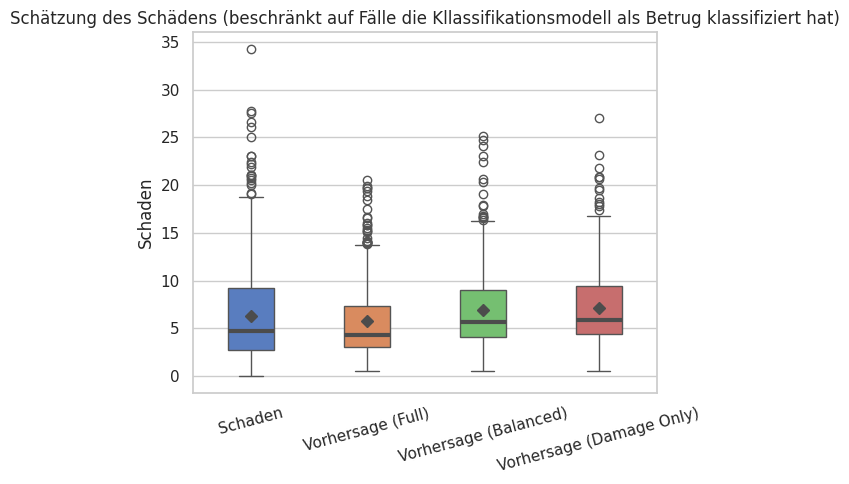

In [ ]:
# Combine the data
df = pd.DataFrame({
    "Error": list(true_damage)
             + list(predicted_damage_full)
             + list(predicted_damage_balanced)
             + list(predicted_damage_damage_only),
    "Group": ["Schaden"] * len(true_damage)
             + ["Vorhersage (Full)"] * len(predicted_damage_full)
             + ["Vorhersage (Balanced)"] * len(predicted_damage_balanced)
             + ["Vorhersage (Damage Only)"] * len(predicted_damage_damage_only)
})

# Generate a seaborn-compatible color palette
groups = df["Group"].unique()
palette = dict(zip(groups, sns.color_palette("muted", len(groups))))

# Plot
plt.figure(figsize=(6, 5))
sns.set_theme(style="whitegrid")
plt.title("Boxplot der Schadenvorhersagefehler (Full Data)")
sns.boxplot(x="Group", y="Error", data=df, palette=palette, hue="Group", width=0.4,
            medianprops=dict(color="#4c4c4c", linewidth=3),
            meanprops=dict(marker="D", markerfacecolor="#4c4c4c", markeredgecolor="#4c4c4c"),
            showmeans=True
            )
plt.title("Schätzung des Schädens (beschränkt auf Fälle die Kllassifikationsmodell als Betrug klassifiziert hat)")
plt.xlabel("")
plt.ylabel("Schaden")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
